In [1]:
import sys
import os

# 获取当前工作目录
current_dir = os.getcwd()

# 添加项目根目录到 sys.path
project_dir = os.path.abspath(os.path.join(current_dir, './'))
# print(project_dir)
sys.path.append(project_dir)


In [2]:
import re
from typing import List
import numpy as np
import editdistance
from collections import defaultdict


# from pylatexenc.latexwalker import LatexWalker, 

from pylatexenc.latexwalker import LatexWalker
from sklearn.metrics import precision_score, recall_score, f1_score


In [3]:
def load_lns(fpath: str) -> List[str]:
    lns = []
    with open(fpath, "r") as f:
        for ln in f.readlines():
            lns.append(ln.strip())
    return lns

read test caption answer

In [4]:
test_dir = "../data/test"
test_caption_dir = os.path.join(test_dir,'caption.txt')
print(test_caption_dir)
caption_dict = {}

captions = load_lns(test_caption_dir)
max_caption_size = 0
count = 0
for cap in captions:
    img_name = cap.split()[0]
    caption_dict[img_name] = cap.split()[1:]
    if len(caption_dict[img_name]) > max_caption_size:
        max_caption_size = len(caption_dict[img_name])
    if len(caption_dict[img_name]) >= 600:
        count += 1
print(" max caption size ",max_caption_size)
print(count)
print(len(caption_dict.keys()),list(caption_dict.keys())[:5])      
print(caption_dict[list(caption_dict.keys())[0]])     

../data/test/caption.txt
 max caption size  823
7
3000 ['0054734', '0037174', '0031510', '0083407', '0037881']
['\\begin', '{aligned}', '\\boldsymbol', '{', 'K', '}', '=', '\\left', '(', '\\begin', '{array}', '{', 'c', 'c', 'c', '}', '0', '&', '0', '&', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'p', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'm', '}', '}', '}', '\\\\', '0', '&', '0', '&', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'm', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'm', '}', '}', '}', '\\\\', '\\mathcal', '{', 'P', '}', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'f', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'p', '}', '}', '}', '&', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'f', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'f', '}', '}', '}', '&', '0', '\\end', '{array}', '\\right', ')', '\\end', '{aligned}']


In [5]:
version = 78
ckp_folder = os.path.join("lightning_logs", f"version_{version}", "checkpoints")

In [6]:
pred_dir = '../result'
pred_files = os.listdir(pred_dir)
pred_dict = {}

for pred_file in pred_files:
    with open(os.path.join(pred_dir, pred_file), 'r',encoding='utf-8') as f:
            latex = f.readlines()[1].strip()
            if latex[0] == '$' and latex[-1] == '$':
                # replace start and end '$'
                latex = latex[1:-1]
            pred_dict[pred_file.split(".")[0]] = latex.split()
        
print(len(pred_dict.keys()),list(pred_dict.keys())[:5])

print(pred_dict[list(pred_dict.keys())[0]])

2993 ['0004028', '0109606', '0035325', '0097565', '0011280']
['\\begin', '{aligned}', 'm', '_', '{', 'l', '}', '=', '\\left', '(', '\\begin', '{array}', '{', 'c', 'c', 'c', '}', '0', '.', '0', '0', '2', '5', '6', '&', '-', '0', '.', '0', '1', '0', '5', '8', '&', '0', '\\\\', '-', '0', '.', '0', '1', '0', '5', '8', '&', '0', '.', '0', '4', '5', '9', '6', '&', '0', '\\\\', '0', '&', '0', '&', '1', '\\end', '{array}', '\\right', ')', 'm', '_', '{', '\\tau', '}', '\\end', '{aligned}']


In [7]:

def calculate_edit_distance(seq1, seq2):
    """计算两个Latex序列之间的编辑距离"""
    return editdistance.eval(seq1, seq2)


def calculate_accuracy(pred_dict, true_dict):
    """计算预测结果与真实结果之间的准确率"""
    correct_count = 0
    total_count = 0
    for key in pred_dict:
        if key in true_dict:
            pred_seq = pred_dict[key]
            true_seq = true_dict[key]
            if pred_seq == true_seq:
                correct_count += 1
            total_count += 1
    return correct_count / total_count if total_count > 0 else 0


def calculate_precision_recall_f1(pred_dict, true_dict):
    """计算精确度、召回率和F1分数"""
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for key in pred_dict:
        if key in true_dict:
            pred_seq = pred_dict[key]
            true_seq = true_dict[key]
            # 转换为二进制分类
            true_labels = [1] * len(true_seq)
            pred_labels = [1 if i < len(pred_seq) and pred_seq[i] == true_seq[i] else 0 for i in range(len(true_seq))]
            if len(pred_labels) < len(true_labels):
                pred_labels.extend([0] * (len(true_labels) - len(pred_labels)))
            all_precisions.append(precision_score(true_labels, pred_labels))
            all_recalls.append(recall_score(true_labels, pred_labels))
            all_f1s.append(f1_score(true_labels, pred_labels))

    avg_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
    avg_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
    avg_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

    return avg_precision, avg_recall, avg_f1

def is_valid_latex(seq):
    """检查LaTeX序列是否合法"""
    latex_str = ''.join(seq)
    try:
        walker = LatexWalker(latex_str)
        nodes, pos, len_ = walker.get_latex_nodes()
        return True
    except ...:
        return False

def evaluate_by_length_intervals(pred_dict, true_dict, intervals):
    """按长度区间计算准确率、编辑距离和合法性"""
    interval_results = defaultdict(lambda: {
        'correct_count': 0, 
        'total_count': 0, 
        'total_edit_distance': 0,
        'invalid_count': 0
    })

    for key in pred_dict:
        if key in true_dict:
            pred_seq = pred_dict[key]
            true_seq = true_dict[key]
            length = len(true_seq)
            for start, end in intervals:
                if start <= length < end:
                    interval_results[(start, end)]['total_count'] += 1
                    interval_results[(start, end)]['total_edit_distance'] += calculate_edit_distance(pred_seq, true_seq)
                    if pred_seq == true_seq:
                        interval_results[(start, end)]['correct_count'] += 1
                    if not is_valid_latex(pred_seq):
                        interval_results[(start, end)]['invalid_count'] += 1
                    break

    results = {}
    for interval, data in interval_results.items():
        correct_count = data['correct_count']
        total_count = data['total_count']
        total_edit_distance = data['total_edit_distance']
        invalid_count = data['invalid_count']
        accuracy = correct_count / total_count if total_count > 0 else 0
        average_edit_distance = total_edit_distance / total_count if total_count > 0 else 0
        results[interval] = {
            'accuracy': accuracy,
            'average_edit_distance': average_edit_distance,
            'total_count': total_count,
            'invalid_count': invalid_count
        }

    return results


In [8]:
# 定义长度区间
intervals = [(0, 100), (100, 200), (200, 300), (300,400),(400,600),(600,700),(700,800),(800,900),(900,1000)]
true_dict = caption_dict


In [9]:

# 计算整体准确率
overall_accuracy = calculate_accuracy(pred_dict, caption_dict)
print(f'Overall Accuracy: {overall_accuracy}')

# 计算精确度、召回率和F1分数
avg_precision, avg_recall, avg_f1 = calculate_precision_recall_f1(pred_dict, true_dict)
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')

# 计算各长度区间的指标
interval_results = evaluate_by_length_intervals(pred_dict, true_dict, intervals)

# 调试输出
print(f'Interval Results: {interval_results}')

for interval, metrics in interval_results.items():
    print(f'Interval {interval}: Accuracy = {metrics["accuracy"]}, Average Edit Distance = {metrics["average_edit_distance"]}, Total Count = {metrics["total_count"]}, Invalid Count = {metrics["invalid_count"]}')

Overall Accuracy: 0.5676578683595055
Average Precision: 1.0
Average Recall: 0.7586926642934555
Average F1 Score: 0.7968974208954378
Interval Results: {(0, 100): {'accuracy': 0.6905286343612335, 'average_edit_distance': 1.3403083700440528, 'total_count': 908, 'invalid_count': 0}, (100, 200): {'accuracy': 0.5908127208480566, 'average_edit_distance': 2.7180212014134275, 'total_count': 1415, 'invalid_count': 0}, (200, 300): {'accuracy': 0.41954022988505746, 'average_edit_distance': 11.195402298850574, 'total_count': 522, 'invalid_count': 0}, (400, 600): {'accuracy': 0.0, 'average_edit_distance': 157.52777777777777, 'total_count': 36, 'invalid_count': 0}, (300, 400): {'accuracy': 0.15178571428571427, 'average_edit_distance': 33.169642857142854, 'total_count': 112, 'invalid_count': 0}}
Interval (0, 100): Accuracy = 0.6905286343612335, Average Edit Distance = 1.3403083700440528, Total Count = 908, Invalid Count = 0
Interval (100, 200): Accuracy = 0.5908127208480566, Average Edit Distance = 2.

分析模型分析错误的原因，图片分辨率，过长？ 还是。

标准化。
测其他的指标

  ground truth image 


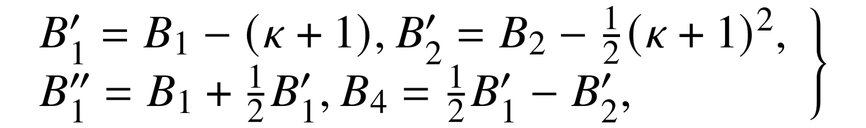

['\\begin', '{aligned}', '\\left', '.', '\\begin', '{array}', '{', 'l', 'l', '}', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '}', '=', 'B', '_', '{', '1', '}', '-', '(', '\\kappa', '+', '1', ')', ',', 'B', '_', '{', '2', '}', '^', '{', '\\prime', '}', '=', 'B', '_', '{', '2', '}', '-', '\\frac', '{', '1', '}', '{', '2', '}', '(', '\\kappa', '+', '1', ')', '^', '{', '2', '}', ',', '\\\\', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '\\prime', '}', '=', 'B', '_', '{', '1', '}', '+', '\\frac', '{', '1', '}', '{', '2', '}', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '}', ',', 'B', '_', '{', '4', '}', '=', '\\frac', '{', '1', '}', '{', '2', '}', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '}', '-', 'B', '_', '{', '2', '}', '^', '{', '\\prime', '}', ',', '\\end', '{array}', '\\right', '\\}', '\\end', '{aligned}']


<IPython.core.display.Math object>

 pred latex image
['\\begin', '{aligned}', '\\left', '.', '\\begin', '{array}', '{', 'l', '}', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '}', '=', 'B', '_', '{', '1', '}', '-', '(', '\\kappa', '+', '1', ')', ',', 'B', '_', '{', '2', '}', '^', '{', '\\prime', '}', '=', 'B', '_', '{', '2', '}', '-', '\\frac', '{', '1', '}', '{', '2', '}', '(', '\\kappa', '+', '1', ')', '^', '{', '2', '}', ',', '\\\\', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '\\prime', '}', '=', 'B', '_', '{', '1', '}', '+', '\\frac', '{', '1', '}', '{', '2', '}', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '}', ',', 'B', '_', '{', '4', '}', '=', '\\frac', '{', '1', '}', '{', '2', '}', 'B', '_', '{', '1', '}', '^', '{', '\\prime', '}', '-', 'B', '_', '{', '2', '}', '^', '{', '\\prime', '}', ',', '\\end', '{array}', '\\right', '\\}', '\\end', '{aligned}']


<IPython.core.display.Math object>

edit distance :    1
the length of caption latex is  139
The LaTeX sequences are not equivalent.


In [15]:
import re

def extract_symbols(latex_str):
    symbols = re.findall(r'[a-zA-Z]+|\d+|\\[a-zA-Z]+', latex_str)
    return sorted(symbols)

def compare_latex_symbols(latex1, latex2):
    symbols1 = extract_symbols(latex1)
    symbols2 = extract_symbols(latex2)
    return symbols1 == symbols2


import random
from PIL import Image
from IPython.display import display, Math
test_img_path = os.path.join(test_dir,"img")
test_img_files = os.listdir(test_img_path)

random_img_file = random.choice(test_img_files)
random_img_path = os.path.join(test_img_path,random_img_file)

print("  ground truth image ")
display(Image.open(random_img_path))

caption_latex = caption_dict[random_img_file.split(".")[0]]

print(caption_latex)
display(Math(" ".join(caption_latex)))



print(" pred latex image")
pred_latex=  pred_dict[random_img_file.split(".")[0]]
print(pred_latex)
display(Math(" ".join(pred_latex)))



print("edit distance :   ",editdistance.eval(pred_latex,caption_latex))

if editdistance.eval(pred_latex,caption_latex)!=0:
    # print the len 

    
    print("the length of caption latex is ",len(caption_latex))

if compare_latex_symbols(" ".join(pred_latex)," ".join(caption_latex)):
    print("The LaTeX sequences are equivalent.")
else:
    print("The LaTeX sequences are not equivalent.")    


In [11]:
# import sympy as sp
# from sympy.parsing.latex import parse_latex

# # 提供的LaTeX表达式列表
# latex_expr1_list = ['\\begin', '{array}', '{', 'l', '}', 'p', '(', '\\phi', '\\xi', ')', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '-', '1', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '}', '}', '\\\\', '=', '-', 'q', '(', '\\psi', '\\xi', ')', '\\psi', '_', '{', 'x', '}', '^', '{', 'q', '-', '1', '}', '\\cdot', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '}', '\\\\', '=', 'p', 'q', '(', '\\phi', '\\psi', ')', '\\phi', '_', '{', 'x', '^', '{', 'p', '-', '1', '}', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '-', '1', '}', '}', '\\end', '{array}']

# latex_expr2_list = ['\\begin', '{aligned}', '&', 'p', '(', '\\phi', '\\xi', ')', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '-', '1', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '}', '}', '\\\\', '&', '=', '-', 'q', '(', '\\psi', '\\xi', ')', '\\psi', '_', '{', 'x', '}', '^', '{', 'q', '-', '1', '}', '\\cdot', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '}', '\\\\', '&', '=', 'p', 'q', '(', '\\phi', '\\psi', ')', '\\phi', '_', '{', 'x', '^', '{', 'p', '-', '1', '}', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '-', '1', '}', '}', '\\end', '{aligned}']

# # 移除LaTeX环境标记函数
# def remove_latex_env(latex_list):
#     ignore_tokens = {'\\begin', '\\end', '{array}', '{aligned}', '&', '{', '}', '\\\\'}
#     return ''.join([token for token in latex_list if token not in ignore_tokens])

# # 移除LaTeX环境标记
# latex_expr1_cleaned = remove_latex_env(latex_expr1_list)
# latex_expr2_cleaned = remove_latex_env(latex_expr2_list)

# # 打印转换后的字符串
# print("LaTeX Expr 1:", latex_expr1_cleaned)
# print("LaTeX Expr 2:", latex_expr2_cleaned)

# # 尝试将清理后的表达式转换为SymPy表达式
# try:
#     expr1 = parse_latex(latex_expr1_cleaned)
#     expr2 = parse_latex(latex_expr2_cleaned)
# except Exception as e:
#     print("Error parsing LaTeX expressions:", e)
#     expr1 = None
#     expr2 = None

# # 如果解析成功，则进行比较
# if expr1 and expr2:
#     # 方法1: 数学简化和标准化
#     simplified_expr1 = sp.simplify(expr1)
#     simplified_expr2 = sp.simplify(expr2)
#     print("Simplified expressions are equal:", simplified_expr1 == simplified_expr2)

#     # 方法2: 符号比较
#     expanded_expr1 = sp.expand(expr1)
#     expanded_expr2 = sp.expand(expr2)
#     print("Expanded expressions are equal:", expanded_expr1 == expanded_expr2)

#     # 方法3: 结构化比较
#     tree_expr1 = sp.srepr(expr1)
#     tree_expr2 = sp.srepr(expr2)
#     print("Expression trees are equal:", tree_expr1 == tree_expr2)

#     # 方法5: 符号推理和代数恒等式
#     simplified_expr1 = sp.simplify(expr1)
#     simplified_expr2 = sp.simplify(expr2)
#     print("Symbolically simplified expressions are equal:", simplified_expr1 == simplified_expr2)

#     # 方法6: LaTeX 语法和解析工具
#     # 使用 SymPy 解析 LaTeX 表达式并进行比较
#     latex_expr1_sympy = sp.sympify(sp.latex(expr1))
#     latex_expr2_sympy = sp.sympify(sp.latex(expr2))
#     print("Parsed LaTeX expressions are equal:", latex_expr1_sympy == latex_expr2_sympy)
# else:
#     print("Parsing failed, unable to compare expressions.")

LaTeX Expr 1: lp(\phi\xi)\phi_x^p-1\cdot\psi_x^q=-q(\psi\xi)\psi_x^q-1\cdot\phi_x^p=pq(\phi\psi)\phi_x^p-1\cdot\psi_x^q-1
LaTeX Expr 2: p(\phi\xi)\phi_x^p-1\cdot\psi_x^q=-q(\psi\xi)\psi_x^q-1\cdot\phi_x^p=pq(\phi\psi)\phi_x^p-1\cdot\psi_x^q-1
Error parsing LaTeX expressions: 'NoneType' object is not callable
Parsing failed, unable to compare expressions.


Ground truth image:


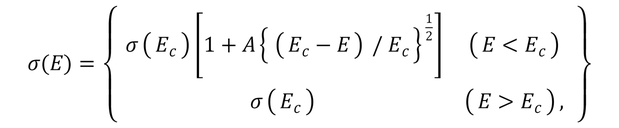

Caption LaTeX:


<IPython.core.display.Math object>

Predicted LaTeX:


<IPython.core.display.Math object>

Edit distance: 32
Length of caption LaTeX: 135
Length of predicted LaTeX: 105
Edit Path:
Delete: \mathscr
Delete: {
Delete: }
Replace: l -> c
Replace: l -> c
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
Delete: \mathscr
Delete: {
Delete: }
The LaTeX sequences are not equivalent.


In [138]:
import os
import re
import random
from PIL import Image
from IPython.display import display, Math
import difflib
import editdistance

# 提取符号的函数
def extract_symbols(latex_str):
    symbols = re.findall(r'[a-zA-Z]+|\d+|\\[a-zA-Z]+|[^a-zA-Z\d\s\\]', latex_str)
    return symbols

# 生成编辑路径并显示具体的编辑操作
def generate_edit_path(latex1, latex2):
    symbols1 = extract_symbols(latex1)
    symbols2 = extract_symbols(latex2)
    
    matcher = difflib.SequenceMatcher(None, symbols1, symbols2)
    edit_path = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i in range(i1, i2):
                edit_path.append(('match', symbols1[i], symbols2[j1 + (i - i1)]))
        elif tag == 'replace':
            for i in range(i1, i2):
                edit_path.append(('replace', symbols1[i], symbols2[j1 + (i - i1)]))
        elif tag == 'delete':
            for i in range(i1, i2):
                edit_path.append(('delete', symbols1[i], ''))
        elif tag == 'insert':
            for j in range(j1, j2):
                edit_path.append(('insert', '', symbols2[j]))
    
    return edit_path

# 打印编辑路径
def print_edit_path(edit_path):
    for action, sym1, sym2 in edit_path:
        # if action == 'match':
        #     print(f"Match: {sym1} == {sym2}")
        if action == 'replace':
            print(f"Replace: {sym1} -> {sym2}")
        elif action == 'delete':
            print(f"Delete: {sym1}")
        elif action == 'insert':
            print(f"Insert: {sym2}")

# 比较符号是否等价
def compare_latex_symbols(latex1, latex2):
    symbols1 = extract_symbols(latex1)
    symbols2 = extract_symbols(latex2)
    return sorted(symbols1) == sorted(symbols2)

# 测试数据
# test_dir = "path/to/your/test_directory"  # 修改为你的测试目录路径
# caption_dict = {"example_key": ["\\phi", "=", "a", "+", "b"]}  # 修改为你的caption字典
# pred_dict = {"example_key": ["\\phi", "=", "a", "-", "b"]}  # 修改为你的预测字典

# 随机选择一个测试图像
test_img_path = os.path.join(test_dir, "img")
test_img_files = os.listdir(test_img_path)
random_img_file = random.choice(test_img_files)
random_img_path = os.path.join(test_img_path, random_img_file)

print("Ground truth image:")
display(Image.open(random_img_path))

caption_latex = caption_dict[random_img_file.split(".")[0]]
print("Caption LaTeX:")
display(Math(" ".join(caption_latex)))

pred_latex = pred_dict[random_img_file.split(".")[0]]
print("Predicted LaTeX:")
display(Math(" ".join(pred_latex)))

# 计算编辑距离
edit_dist = editdistance.eval(pred_latex, caption_latex)
print("Edit distance:", edit_dist)

# 生成并显示编辑路径
if edit_dist != 0:
    edit_path = generate_edit_path(" ".join(caption_latex), " ".join(pred_latex))
    
    print("Length of caption LaTeX:", len(caption_latex))
    print("Length of predicted LaTeX:", len(pred_latex))
    
    print("Edit Path:")
    print_edit_path(edit_path)

# 比较符号是否等价
if compare_latex_symbols(" ".join(pred_latex), " ".join(caption_latex)):
    print("The LaTeX sequences are equivalent.")
else:
    print("The LaTeX sequences are not equivalent.")